In [1]:
from astropy.io import fits
from astropy.wcs import WCS
from glob import glob
from natsort import natsorted

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import numpy as np

from matplotlib.colors import LogNorm

from photutils.detection import DAOStarFinder
from astropy.stats import mad_std

import cometToolkit as comets
import cometToolkit as ctk

from astropy.nddata import Cutout2D

# Investigating Background Subtraction

105241976.73913015


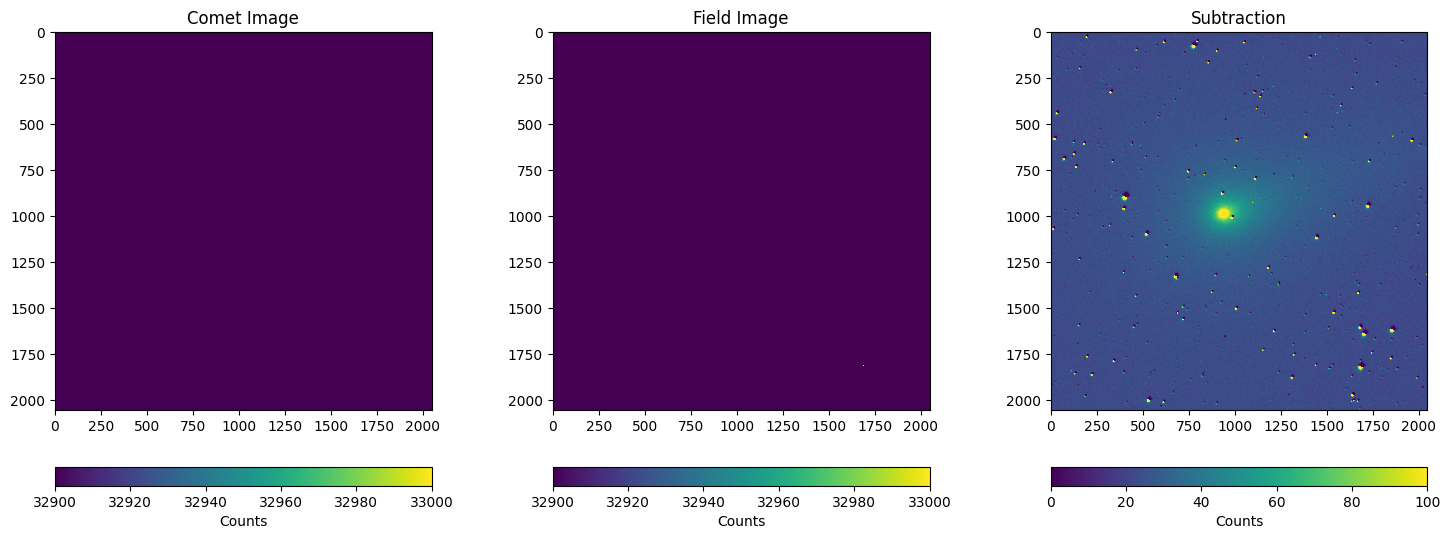

In [6]:
cometImage = ctk.GetImage("../DataProducts/ReducedImages/Day01/V/Comet62P_V00.fits")
backgroundImage = ctk.GetImage("../DataProducts/ReducedImages/Day01/V/Field_V00.fits")

print(np.sum(cometImage - backgroundImage))

#backgroundImage = np.roll(backgroundImage, (-5, 7), axis=(1,0))

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

im0 = axes[0].imshow(cometImage, vmin=32900, vmax=33000)
im1 = axes[1].imshow(backgroundImage, vmin=32900, vmax=33000)
im2 = axes[2].imshow(cometImage - backgroundImage, vmin=0, vmax=100)

axes[0].set_title("Comet Image")
axes[1].set_title("Field Image")
axes[2].set_title("Subtraction")

ims = [im0, im1, im2]
for i, ax in enumerate(axes):
    cax = ax.inset_axes([0, -0.2, 1, 0.05])
    plt.colorbar(ims[i], cax=cax, orientation="horizontal", label="Counts")

#plt.colorbar(im)

plt.tight_layout()

# Image Stacking

### Star Stacking

In [17]:
stackedVField = ctk.StackImages(glob("../DataProducts/ReducedImages/Day01/V/Field_V0*.fits"))
stackedVField = ctk.RollImage(stackedVField, (-4, 7))
ctk.SaveFits(stackedVField, "../DataProducts/ReducedImages/Day01/V/stackedField_V.fits")

FITS image saved to: ../DataProducts/ReducedImages/Day01/V/stackedField_V.fits


### Comet Stacking

##### Basic Plotting

#### Finding the optocentre

In [1]:
import cometToolkit as ctk
import numpy as np
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.io import fits
from natsort import natsorted
from glob import glob

from astropy.nddata import Cutout2D

#### Visualising Stack

In [20]:


day = "Day17"

match day:
    case "Day12":
        wcs = WCS(fits.open("../../Data/wcs/day12.fits")[0].header)
        dayInt = 0

        roughPos=(980, 980)
        cropOffset=[+200, 0]

        vReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{day}/V/*"))[:-2]
        rReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{day}/R/*"))[:-2]
        bReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{day}/B/*"))[:-2]

    case "Day13":
        wcs = WCS(fits.open("../../Data/wcs/day13.fits")[0].header)
        dayInt = 1

        roughPos=(750, 1000)
        cropOffset=[+200, 0]

        vReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{day}/V/*"))[:-4]
        rReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{day}/R/*"))[:-5]
        bReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{day}/B/*"))[:-6]

    case "Day14":
        wcs = WCS(fits.open("../../Data/wcs/day14.fits")[0].header)
        dayInt = 2

        roughPos=(500, 1000)
        cropOffset=[+300, 0]

        vReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{day}/V/*"))[:-2]
        rReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{day}/R/*"))[:-2]
        bReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{day}/B/*"))[:-2]

    case "Day17":
        wcs = WCS(fits.open("../../Data/wcs/day17.fits")[0].header)
        dayInt = 3

        roughPos=(650, 1000)
        cropOffset=[+200, 0]

        # Note: Excluding last few images due to cloud
        vReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{day}/V/*"))[:-2]
        rReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{day}/R/*"))[:-2]
        bReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{day}/B/*"))[:-3]

print(vReducedDataPaths)
print(rReducedDataPaths)
print(bReducedDataPaths)

['../../Python/DataProducts/ReducedImages/Day17/V/Comet62P_V00.fits', '../../Python/DataProducts/ReducedImages/Day17/V/Comet62P_V01.fits', '../../Python/DataProducts/ReducedImages/Day17/V/Comet62P_V02.fits', '../../Python/DataProducts/ReducedImages/Day17/V/Comet62P_V03.fits', '../../Python/DataProducts/ReducedImages/Day17/V/Comet62P_V04.fits', '../../Python/DataProducts/ReducedImages/Day17/V/Comet62P_V05.fits', '../../Python/DataProducts/ReducedImages/Day17/V/Comet62P_V06.fits', '../../Python/DataProducts/ReducedImages/Day17/V/Comet62P_V07.fits', '../../Python/DataProducts/ReducedImages/Day17/V/Comet62P_V08.fits']
['../../Python/DataProducts/ReducedImages/Day17/R/Comet62P_R00.fits', '../../Python/DataProducts/ReducedImages/Day17/R/Comet62P_R01.fits', '../../Python/DataProducts/ReducedImages/Day17/R/Comet62P_R02.fits', '../../Python/DataProducts/ReducedImages/Day17/R/Comet62P_R03.fits', '../../Python/DataProducts/ReducedImages/Day17/R/Comet62P_R04.fits', '../../Python/DataProducts/Reduc

In [5]:
def StackImages(paths, filter, day, roughPosition, size, offset):
    stackingImages = []

    cutouts = []

    for path in paths:
        image = fits.open(path)[0].data

        centre = ctk.FindCometCentre(path, filter, day, roughPosition=roughPosition, maxCentreDistance=50)

        # Here: need to Replace stars with surrouding background

        # Create new fits file centred on the comet
        cutout = Cutout2D(image, (centre[0] + offset[0], centre[1] + offset[1]), size, wcs=wcs)

        cutouts.append(cutout)

    cutoutWcs = cutouts[0].wcs
    for cutout in cutouts:
        stackingImages.append(np.array(cutout.data))
        print(np.shape(cutout.data))

    #print(np.shape(stackingImages))

    stackedImage = np.median(stackingImages, axis=0) # * np.sqrt(len(paths) -> Not using as days with less images are dimmer

    return stackedImage, cutoutWcs

In [10]:
vStackedImage, cutoutWcs = StackImages(vReducedDataPaths, "V", dayInt, roughPos, 1550, cropOffset)

(1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(4, 1550, 1550)


Text(0, 0.5, 'Arbitrary Y')

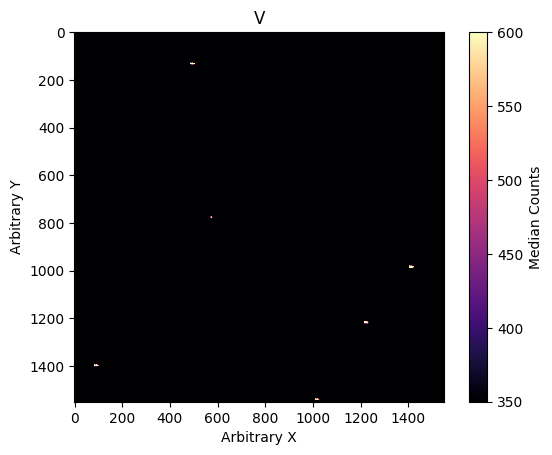

In [11]:
plt.imshow(vStackedImage, cmap="magma", vmin=350, vmax=600)
plt.colorbar(label="Median Counts")
plt.title("V")
plt.xlabel("Arbitrary X")
plt.ylabel("Arbitrary Y")

In [12]:
rStackedImage, _ = StackImages(rReducedDataPaths, "R", dayInt, roughPos, 1550, cropOffset)

(1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(4, 1550, 1550)


Text(0, 0.5, 'Arbitrary Y')

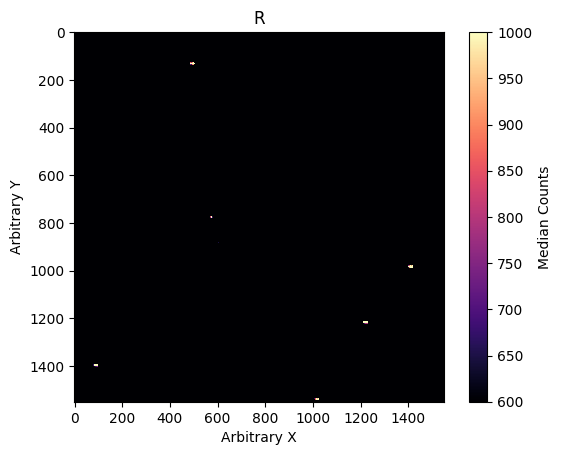

In [13]:
plt.imshow(rStackedImage, cmap="magma", vmin=600, vmax=1000)
plt.colorbar(label="Median Counts")
plt.title("R")
plt.xlabel("Arbitrary X")
plt.ylabel("Arbitrary Y")

In [15]:
bStackedImage, _ = StackImages(bReducedDataPaths, "B", dayInt, roughPos, 982, cropOffset)

(982, 982)
(982, 982)
(982, 982)
(982, 982)
(4, 982, 982)


Text(0, 0.5, 'Arbitrary Y')

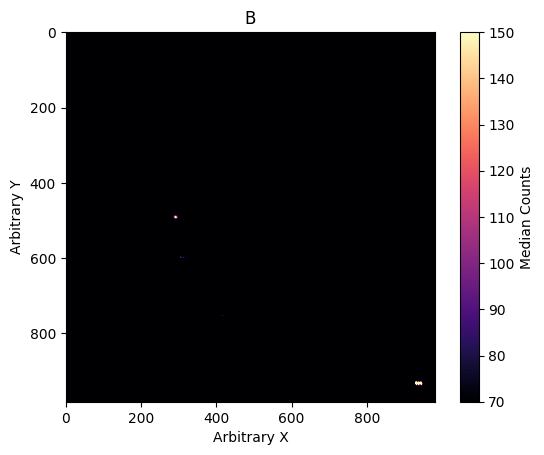

In [16]:
plt.imshow(bStackedImage, cmap="magma", vmin=70, vmax=150)
plt.colorbar(label="Median Counts")
plt.title("B")
plt.xlabel("Arbitrary X")
plt.ylabel("Arbitrary Y")

In [17]:
ctk.SaveFits(vStackedImage, f"../DataProducts/StackedImages/{day}/vStacked.fits")
ctk.SaveFits(rStackedImage, f"../DataProducts/StackedImages/{day}/rStacked.fits")
ctk.SaveFits(bStackedImage, f"../DataProducts/StackedImages/{day}/bStacked.fits")

5186.731011270184
5186.731011270184
FITS image saved to: ../DataProducts/StackedImages/Day13/vStacked.fits
8745.611163742258
8745.611163742258
FITS image saved to: ../DataProducts/StackedImages/Day13/rStacked.fits
1627.7569312885184
1627.7569312885184
FITS image saved to: ../DataProducts/StackedImages/Day13/bStacked.fits


##### Automated Stack

In [6]:
from tqdm import tqdm

days = ["Day12", "Day13", "Day14", "Day17"]

for day in tqdm(days):
    match day:
        case "Day12":
            wcs = WCS(fits.open("../../Data/wcs/day12.fits")[0].header)
            dayInt = 0

            roughPos=(980, 980)
            cropOffset=[+200, 0]

            vReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{day}/V/*"))[:-2]
            rReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{day}/R/*"))[:-2]
            bReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{day}/B/*"))[:-2]

        case "Day13":
            wcs = WCS(fits.open("../../Data/wcs/day13.fits")[0].header)
            dayInt = 1

            roughPos=(750, 1000)
            cropOffset=[+200, 0]

            vReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{day}/V/*"))[:-4]
            rReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{day}/R/*"))[:-5]
            bReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{day}/B/*"))[:-6]

        case "Day14":
            wcs = WCS(fits.open("../../Data/wcs/day14.fits")[0].header)
            dayInt = 2

            roughPos=(500, 1000)
            cropOffset=[+300, 0]

            vReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{day}/V/*"))[:-2]
            rReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{day}/R/*"))[:-2]
            bReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{day}/B/*"))[:-2]

        case "Day17":
            wcs = WCS(fits.open("../../Data/wcs/day17.fits")[0].header)
            dayInt = 3

            roughPos=(650, 1000)
            cropOffset=[+200, 0]

            # Note: Excluding last few images due to cloud
            vReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{day}/V/*"))[:-2]
            rReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{day}/R/*"))[:-2]
            bReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{day}/B/*"))[:-3]

    vStackedImage, _ = StackImages(vReducedDataPaths, "V", dayInt, roughPos, 1550, cropOffset)
    rStackedImage, _ = StackImages(rReducedDataPaths, "R", dayInt, roughPos, 1550, cropOffset)
    bStackedImage, _ = StackImages(bReducedDataPaths, "B", dayInt, roughPos, 1550, cropOffset)

    ctk.SaveFits(vStackedImage, f"../DataProducts/StackedImages/{day}/vStacked.fits")
    ctk.SaveFits(rStackedImage, f"../DataProducts/StackedImages/{day}/rStacked.fits")
    ctk.SaveFits(bStackedImage, f"../DataProducts/StackedImages/{day}/bStacked.fits")

  0%|          | 0/4 [00:00<?, ?it/s]

(1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(7, 1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(7, 1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(7, 1550, 1550)


 25%|██▌       | 1/4 [00:25<01:16, 25.49s/it]

1243.1588561423985
1243.1588561423985
FITS image saved to: ../DataProducts/StackedImages/Day12/vStacked.fits
2206.9751166822243
2206.9751166822243
FITS image saved to: ../DataProducts/StackedImages/Day12/rStacked.fits
299.54828284048693
299.54828284048693
FITS image saved to: ../DataProducts/StackedImages/Day12/bStacked.fits


(1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(4, 1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(4, 1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(4, 1550, 1550)


 50%|█████     | 2/4 [00:40<00:38, 19.07s/it]

5186.731011270184
5186.731011270184
FITS image saved to: ../DataProducts/StackedImages/Day13/vStacked.fits
8745.611163742258
8745.611163742258
FITS image saved to: ../DataProducts/StackedImages/Day13/rStacked.fits
2243.845106156107
2243.845106156107
FITS image saved to: ../DataProducts/StackedImages/Day13/bStacked.fits


(1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(7, 1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(7, 1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(7, 1550, 1550)


 75%|███████▌  | 3/4 [01:05<00:21, 21.96s/it]

1146.1934129991255
1146.1934129991255
FITS image saved to: ../DataProducts/StackedImages/Day14/vStacked.fits
2087.1425090032767
2087.1425090032767
FITS image saved to: ../DataProducts/StackedImages/Day14/rStacked.fits
324.0734646512735
324.0734646512735
FITS image saved to: ../DataProducts/StackedImages/Day14/bStacked.fits


(1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(9, 1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(9, 1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(1550, 1550)
(8, 1550, 1550)


100%|██████████| 4/4 [01:37<00:00, 24.31s/it]

868.8456861609728
868.8456861609728
FITS image saved to: ../DataProducts/StackedImages/Day17/vStacked.fits
1431.8989721395726
1431.8989721395726
FITS image saved to: ../DataProducts/StackedImages/Day17/rStacked.fits
197.7368460265307
197.7368460265307
FITS image saved to: ../DataProducts/StackedImages/Day17/bStacked.fits
